In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
import seaborn as sb
%matplotlib inline

The goal is to predict the operating condition of a waterpoint for each record in the dataset. We are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* ~~date_recorded - The date the row was entered~~
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* ~~wpt_name - Name of the waterpoint if there is one~~
* ~~num_private~~ wtf is this?
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* ~~recorded_by - Group entering this row of data~~
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

In [49]:
trainValues = pd.read_csv('train_values.csv', parse_dates = True)
trainLabels = pd.read_csv('train_labels.csv')

In [3]:
trainValues.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
trainLabels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [62]:
# Predefine functions
# Function to draw trees
def Decision_Tree_Image(decision_tree, feature_names, name = "temp"):
    # Export decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file = 'images/' + name + '.dot', feature_names = feature_names)
    
    # Call graphviz to make an image file from tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the png image
    return Image(filename = "images/" + name + ".png")

# Function to draw 2D scatterplots
def Plot_Data(data, var1, var2, targetVar):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Pretty colors for dots
    color = ['red' if x == 'non functional' else 'blue' if x == 'functional' else 'green' for x in data[targetVar]]
    
    # Plot and label
    plt.scatter(data[var1], data[var2], c = color, s = 50)
    plt.xlabel(var1)
    plt.ylabel(var2)

In [50]:
# Merge along id
train = pd.merge(trainValues, trainLabels, on='id')

### Data Exploration

In [51]:
# Make cross table for each column against status to check for patterns
def crossTab(dataframe, refCol):
    colNames = list(dataframe.drop([refCol], 1))
    ctDict = {}
    for i in colNames:
        ctDict['crossTab_{}'.format(i)] = pd.crosstab(dataframe[i], dataframe[refCol])
    return ctDict

tables = crossTab(train, 'status_group')

In [52]:
tables['crossTab_construction_year']

status_group,functional,functional needs repair,non functional
construction_year,,,
0,10555,1789,8365
1960,24,6,72
1961,2,3,16
1962,7,1,22
1963,31,6,48
1964,7,1,32
1965,11,1,7
1966,6,0,11
1967,31,17,40


crossTab_quantity: most 'dry's are non-functional
crossTab_funder: need cleaning
crossTab_installer: need cleaning
crossTab_subvillage: need cleaning, might be fubar
crossTab_region, region_code, district_code: clean. more region codes than both region and district codes, not sure why
crossTab_scheme_name: need cleaning
crossTab_construction_year: lots of missing data

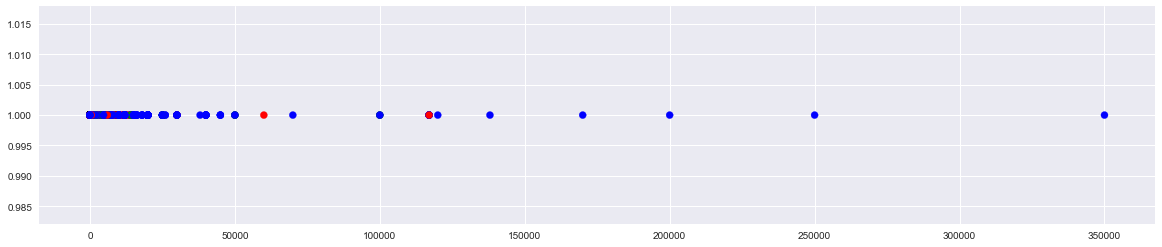

In [55]:
plt.rcParams['figure.figsize'] = [20.0, 4.0]
color = ['red' if x == 'non functional' else 'blue' if x == 'functional' else 'green' for x in train['status_group']]
plt.scatter(train['amount_tsh'], [1] * len(train), c = color, s = 50)

Convert to factors

In [53]:
from sklearn import preprocessing
factorConvert = [x for x in train.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time']]

for factor in factorConvert:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor])

Start tree

In [56]:
list(X)

['id',
 'amount_tsh',
 'date_recorded',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [58]:
Y = train['status_group']
X = train.drop(['status_group', 'date_recorded'], axis = 1)

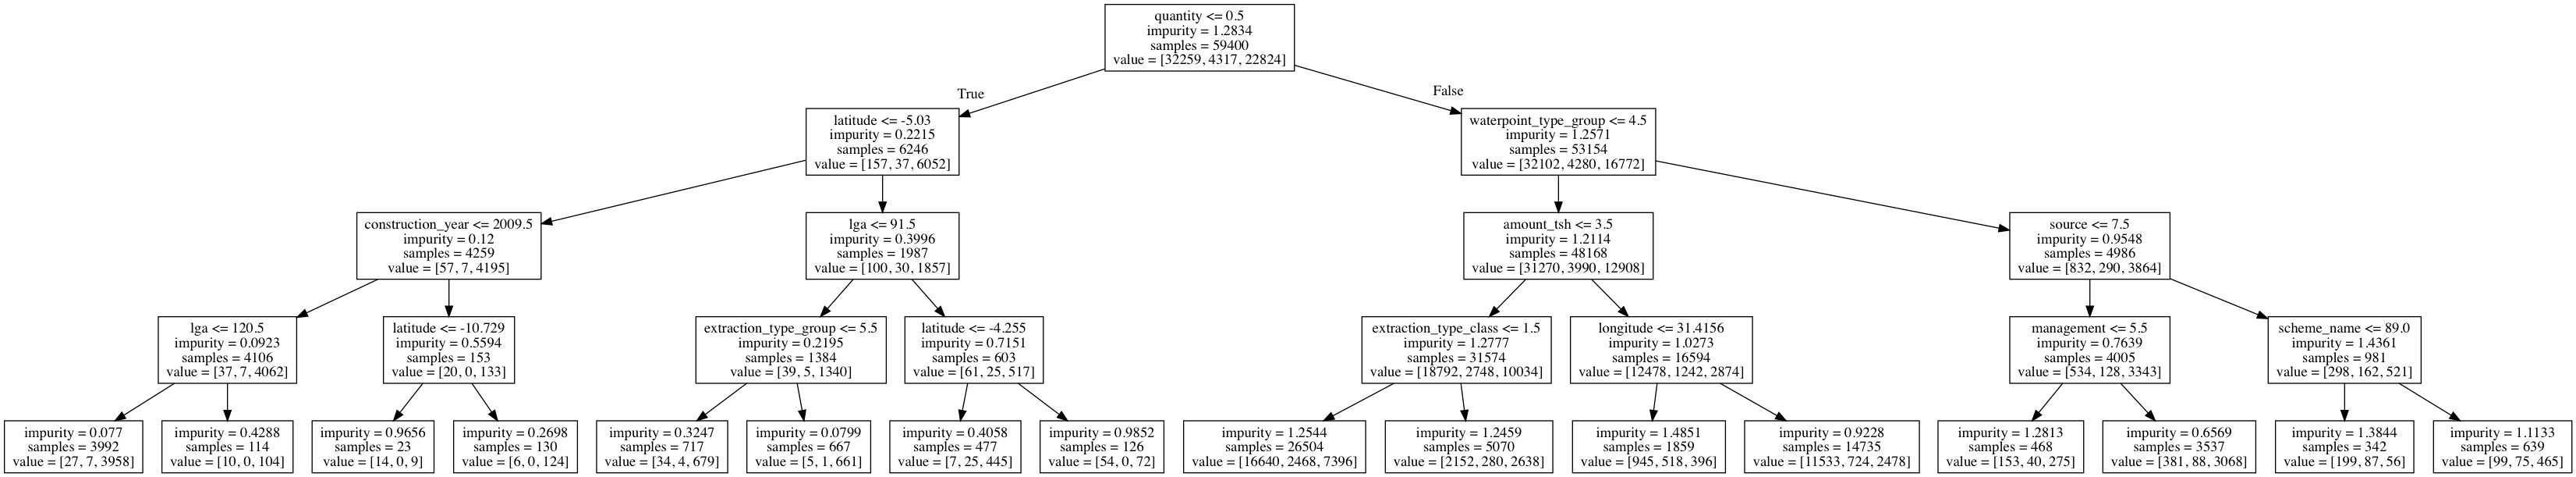

In [65]:
treeEntropy = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
treeEntropy.fit(X, Y)
Decision_Tree_Image(treeEntropy, X.columns)

In [66]:
print "Accuracy score for gini tree is %.3f" %metrics.accuracy_score(treeEntropy.predict(X), Y)

Accuracy score for gini tree is 0.704
